In [1]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox

from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

data_2020 = pd.read_csv('../../data/2020_Notebook02_train_output.csv')

try:
    data_2020.drop('Unnamed: 0',axis=1,inplace=True)
except:
    pass

#We built an extra feature that is not included in notebook2 output. If i have Price per total square meter.
#To build Price per constructed meter I'll have to pivot values.
data_2020['Precio_m2_constr'] = (data_2020['Precio_m2_total'] * data_2020['Area_total'])/data_2020['Area_constr']


#We restricted data only for Lima and Callao.

filter_1 = (data_2020['Ciudad'].isin(['Lima','Callao','Cañete']))
filter_2 = (data_2020['latitud']!= 0)

data_2020.where(filter_1 & filter_2 , inplace=True)

#Import the Lima Shape File per districts.

peru_districts = geopandas.read_file('../../data/GeoShape_Distritos/DISTRITOS.shp')
lima_districts = peru_districts[peru_districts['DEPARTAMEN'] == 'LIMA']

#Aggregate Polygons geometries to get Lima Department Polygon:
lima_department = geopandas.GeoSeries([lima_districts[lima_districts['DEPARTAMEN']=='LIMA'].unary_union])

#Aggregate Polygons geometries to get Lima District Polygon:
lima_province = geopandas.GeoSeries([lima_districts[lima_districts['PROVINCIA']=='LIMA'].unary_union])

#We only awant districts inside Lima.
lima_filter = (peru_districts['DEPARTAMEN'] == 'LIMA') 

lima_districts = peru_districts[lima_filter]

#We need shapely object. We can transform lats and longs into a shapely.Point object

gdf = geopandas.GeoDataFrame(
    data_2020, geometry=geopandas.points_from_xy(data_2020.longitud, data_2020.latitud))

gdf = gdf[gdf['geometry'].apply(lambda x: x.within(lima_department.values[0]))]

#Temporal drop: Since there are many outliers we'll drop some values.
# -------------------------------------------------------------------
gdf = gdf[gdf['Precio_m2_total'] < 9000]

gdf = gdf[gdf['Precio_m2_constr']<11000]

### Spatial Autocorrelation - tests

Our data has absence of spatial randomness? This means if the features that we are interested are correlated with their locations i.e. if a house with the same characteristics has equal value on San Isidro or Chorrillos. A positive value means that the value is related with the near values with respect their locations and a negative correlated value reflects the situation where similar values tend to bel located away from each other.

Statistical similarity is associated with distance.

#### Global Autocorrelation.

Measures the relation between all the spatial variables in our dataset with respect our target variable. If there is correlation our spatial data were not generated through a random process.

In [4]:
from pysal.explore import esda
from pysal.lib import weights
from pysal.viz import splot

from splot.esda import plot_moran

# We filter all of housing point that are inside Lima as a Province.
gdf_province = gdf[gdf['geometry'].apply(lambda x: x.within(lima_province.values[0]))]

In [5]:
#We will get the Spatial Lag of the Square meter Price per Houses, but since this is based on Weights
#First we have to calculate weights with KNN 

gh_df = gdf_province.dissolve(by='geohash_grado8', aggfunc='first')
weights_gh_distance = weights.distance.KNN.from_dataframe(gh_df, k = 6)

weights_gh_distance.transform = 'R' #Row-standarization

gh_df['precio_m2_total_lag'] = weights.spatial_lag.lag_spatial(weights_gh_distance, gh_df['Precio_m2_total'])

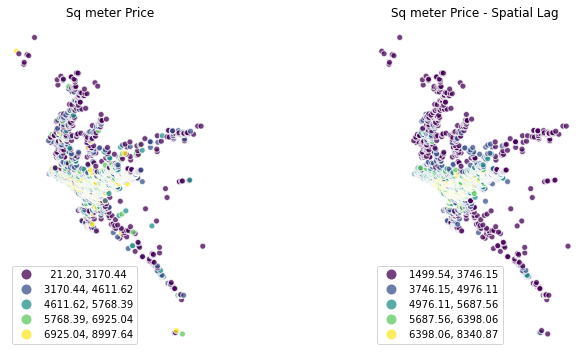

In [6]:
fig, axs = plt.subplots(1,2,figsize=(12,6))

ax1, ax2 = axs

gh_df.plot(column='Precio_m2_total', cmap='viridis', scheme='quantiles',
          k=5, edgecolor='white', alpha=0.75, legend=True, ax=ax1)

ax1.set_axis_off()
ax1.set_title("Sq meter Price")

gh_df.plot(column='precio_m2_total_lag', cmap='viridis', scheme='quantiles',
          k=5, edgecolor='white', alpha=0.75, legend=True, ax=ax2)

ax2.set_axis_off()
ax2.set_title("Sq meter Price - Spatial Lag")

plt.show()

#### Moran's Plot

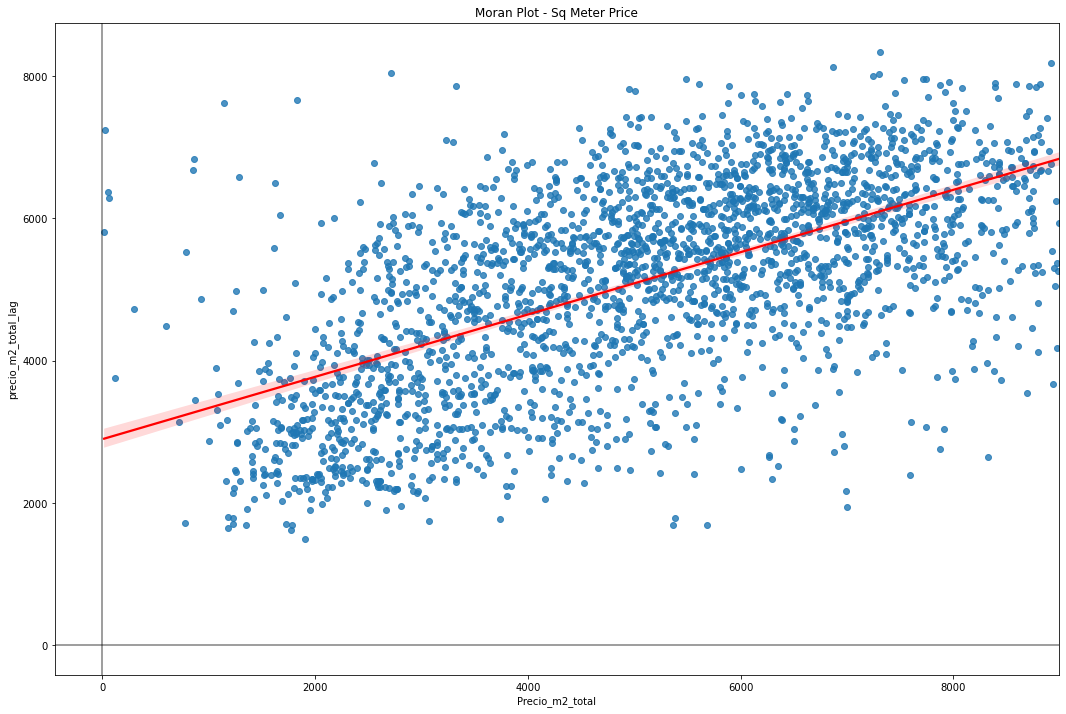

In [8]:
#First we standarize our values
import seaborn as sns
fig,ax = plt.subplots(figsize=(18,12))
gh_df['Precio_m2_total'] = (gh_df['Precio_m2_total'] - gh_df['Precio_m2_total'].mean() / gh_df['Precio_m2_total'].std())

gh_df['precio_m2_total_lag'] = (gh_df['precio_m2_total_lag'] - gh_df['precio_m2_total_lag'].mean() \
                               / gh_df['precio_m2_total_lag'].std())

sns.regplot(x='Precio_m2_total', y='precio_m2_total_lag',  data=gh_df, line_kws={'color':'r'})

ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - Sq Meter Price')
plt.show()

The value of Moran's I corresponds with the slope of the linear fit overlayed on top of the Moran Plot. This could be interpreted as the corr coefficient between our target variable and their respective spatial weights distances.

In [9]:
weights_gh_distance.transform = 'R'
moran = esda.moran.Moran(gh_df['Precio_m2_total'], weights_gh_distance)
moran.I

0.43802208410760124

#### P-value of the likelihood over this pattern is generated by an entirely random process.

H0: Is generated randomly.

H1: Is not generated randomly. The data displays more spatial pattern than we would expect if the values had been randomly alocated to a locations.

In [10]:
#0.001: The data is not generated randomly.
moran.p_sim

0.001

(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.44', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.44)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

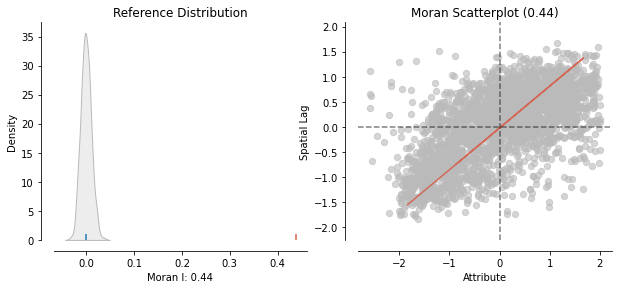

In [11]:
plot_moran(moran)

The difference between Moran's and Geary's stats is that Moran's takes cross-products on the standardized values, and Geary uses differences without standarization. 

That means our spatial relations are stronger while we are not standarazied our data.

In [12]:
geary = esda.geary.Geary(gh_df['Precio_m2_total'], weights_gh_distance)
geary.C

0.5591034569444939

#### Local Spatial Autocorrelation

Measures the relationship between each point and the target variable. This method could be representative for spillovers around our data, we expect to find relationships between fancy neighborhoods across the city that will be not necessary near by each other.

We will use LISA, which is an algorith widely used in many fields to identify geographical clusters of values or find geographcial outliers. They are a very useful tool that can quickly return areas in which values are concentrated and provide suggestive evidence about the processes that might be at work.

<AxesSubplot:ylabel='Density'>

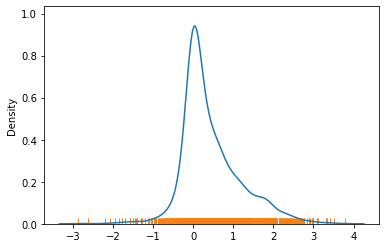

In [13]:
lisa = esda.moran.Moran_Local(gh_df['Precio_m2_total'], weights_gh_distance)

ax = sns.kdeplot(lisa.Is)
sns.rugplot(lisa.Is, ax=ax)

The result shows that are negative and positive associations in their correlation.

<AxesSubplot:>

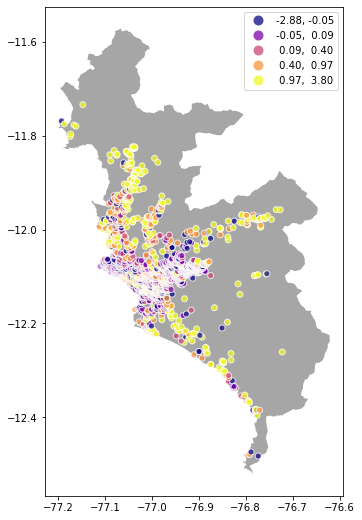

In [27]:
fig, ax = plt.subplots(1,figsize=(9,9))
gh_df['Is'] = lisa.Is
lima_province.plot(ax=ax,color='grey', alpha=0.70) #Plot map
gh_df.plot(column='Is', cmap='plasma', scheme='quantiles',
      k=5, edgecolor='white', alpha=0.75, legend=True, ax=ax)
